In [1]:
!pip install segyio
!pip install segysak
!pip install patchify
!pip install segmentation_models_3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import segyio
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_3D as sm
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from segysak.segy import segy_header_scan, segy_header_scrape, get_segy_texthead, segy_loader
from keras.metrics import MeanIoU
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap

Segmentation Models: using `tf.keras` framework.


/usr/local/lib/python3.7/dist-packages/segysak/segy/_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
train_seismic_path = '/content/drive/MyDrive/UTP_dGB_Documents/data/train/seis'
train_fault_path = '/content/drive/MyDrive/UTP_dGB_Documents/data/train/fault'

valid_seismic_path = '/content/drive/MyDrive/UTP_dGB_Documents/data/validation/seis'
valid_fault_path = '/content/drive/MyDrive/UTP_dGB_Documents/data/validation/fault'

In [6]:
train_seis_input = []
train_fault_output = []

for i in os.listdir(train_seismic_path):
  rand_xl = np.random.randint(0, 128, 1)[0]
  train_seis_input.append(np.reshape(np.fromfile(train_seismic_path+'/'+i,dtype=np.single), (128, 128, 128))[:, rand_xl, :])
  train_fault_output.append(np.reshape(np.fromfile(train_fault_path+'/'+i,dtype=np.single), (128, 128, 128))[:, rand_xl, :])


In [7]:
valid_seis_input = []
valid_fault_output = []

for i in os.listdir(valid_seismic_path):
  rand_xl = np.random.randint(0, 128, 1)[0]
  valid_seis_input.append(np.reshape(np.fromfile(valid_seismic_path+'/'+i,dtype=np.single), (128, 128, 128))[:, rand_xl, :])
  valid_fault_output.append(np.reshape(np.fromfile(valid_fault_path+'/'+i,dtype=np.single), (128, 128, 128))[:, rand_xl, :])


In [8]:
X_train = np.stack((train_seis_input,)*3, axis=-1)
X_test = np.stack((valid_seis_input,)*3, axis=-1)

train_mask = np.expand_dims(train_fault_output, axis=3)
y_train = tf.keras.utils.to_categorical(train_mask, num_classes=2)
test_mask = np.expand_dims(valid_fault_output, axis=3)
y_test = tf.keras.utils.to_categorical(test_mask, num_classes=2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 128, 128, 3)
(20, 128, 128, 3)
(200, 128, 128, 2)
(20, 128, 128, 2)


In [9]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Model

In [10]:
batch_size = 8
image_size = 128

In [11]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [12]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(2, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model


In [13]:
model_unet = UNet()
model_unet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [14]:
train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

In [15]:
history_1 = model_unet.fit(X_train, 
                    y_train,
                    batch_size=batch_size, 
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/100
25/25 [==============================] - 4s 43ms/step - loss: 0.3455 - acc: 0.8734 - val_loss: 0.3119 - val_acc: 0.9128
Epoch 2/100
25/25 [==============================] - 1s 21ms/step - loss: 0.2658 - acc: 0.9279 - val_loss: 0.3020 - val_acc: 0.9128
Epoch 3/100
25/25 [==============================] - 0s 18ms/step - loss: 0.2646 - acc: 0.9279 - val_loss: 0.2967 - val_acc: 0.9128
Epoch 4/100
25/25 [==============================] - 0s 17ms/step - loss: 0.2593 - acc: 0.9279 - val_loss: 0.2942 - val_acc: 0.9128
Epoch 5/100
25/25 [==============================] - 0s 17ms/step - loss: 0.2575 - acc: 0.9279 - val_loss: 0.3169 - val_acc: 0.9128
Epoch 6/100
25/25 [==============================] - 0s 17ms/step - loss: 0.2534 - acc: 0.9279 - val_loss: 0.2982 - val_acc: 0.9128
Epoch 7/100
25/25 [==============================] - 0s 17ms/step - loss: 0.2448 - acc: 0.9279 - val_loss: 0.2775 - val_acc: 0.9128
Epoch 8/100
25/25 [==============================] - 0s 17ms/step - loss: 0.

In [16]:
from tensorflow.keras.utils import plot_model

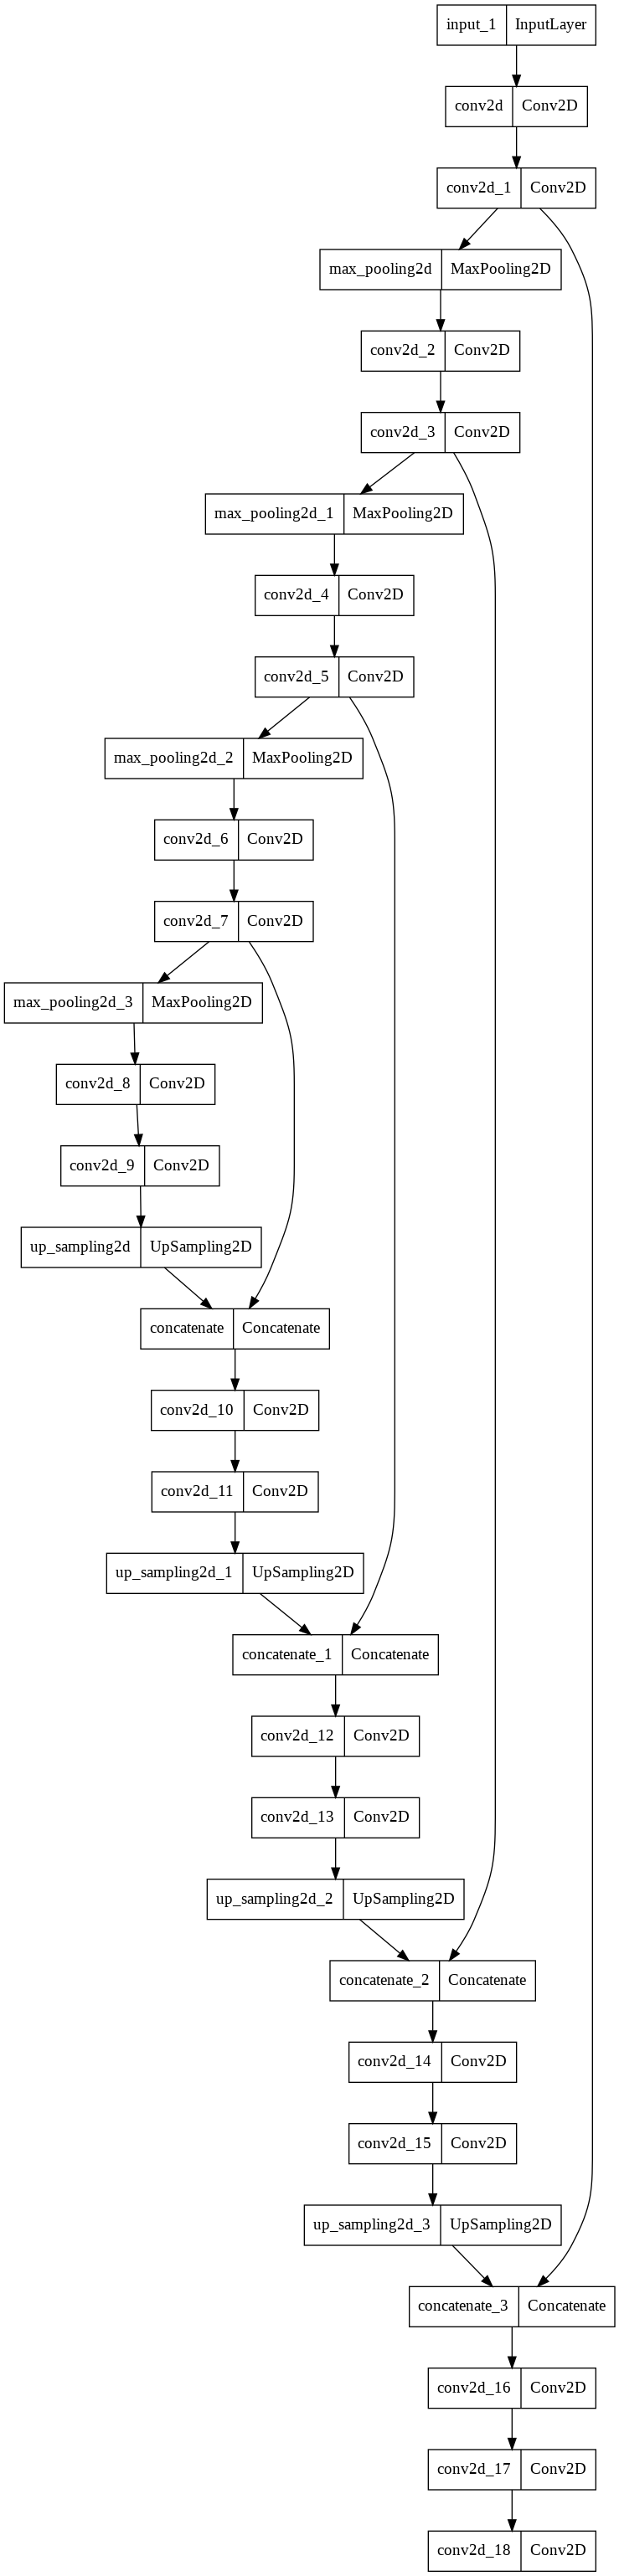

In [17]:
plot_model(model_unet)

In [18]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(2, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

In [19]:
input_shape = (128,128, 3)
model_unet_vgg = build_vgg19_unet(input_shape)
model_unet_vgg.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [20]:
model_unet_vgg.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

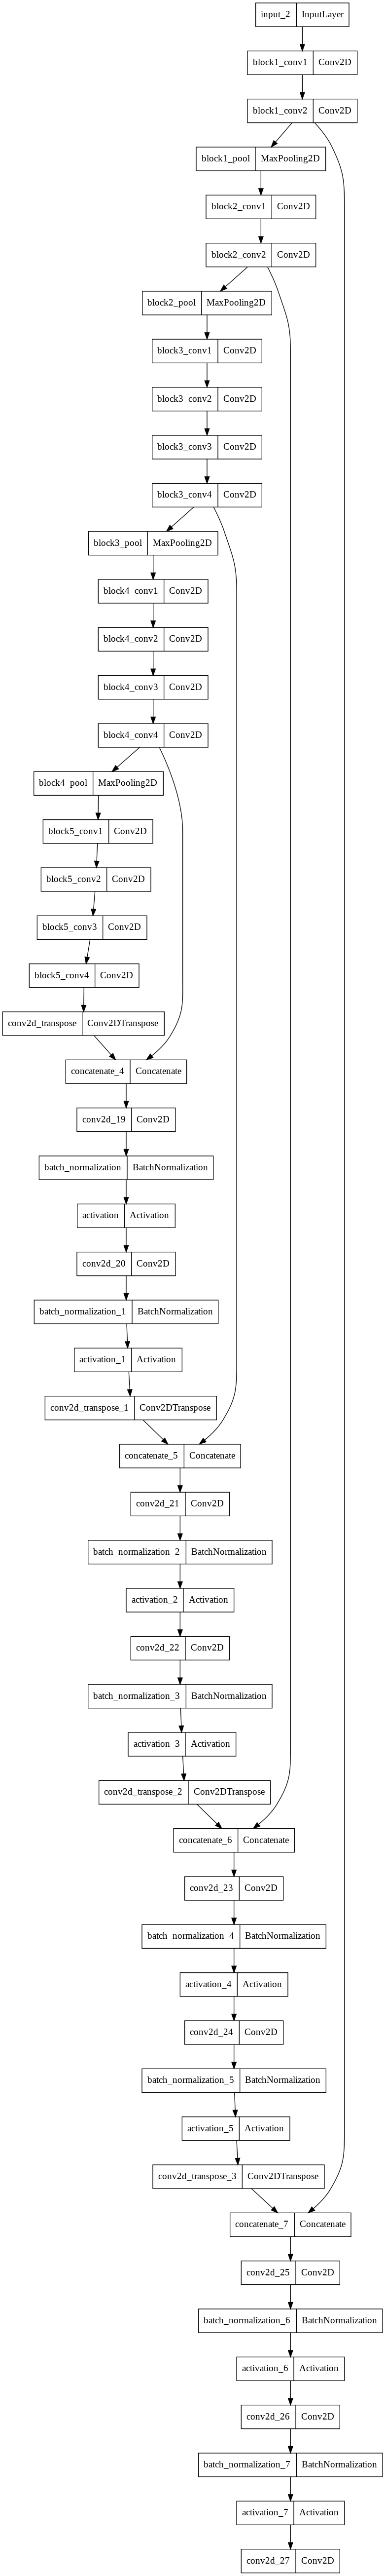

In [21]:
plot_model(model_unet_vgg)

In [22]:
history_2 = model_unet_vgg.fit(X_train, 
                    y_train,
                    batch_size=8, 
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/100
25/25 [==============================] - 6s 116ms/step - loss: 0.4852 - acc: 0.8489 - val_loss: 0.7620 - val_acc: 0.8925
Epoch 2/100
25/25 [==============================] - 2s 79ms/step - loss: 0.2614 - acc: 0.9343 - val_loss: 0.5355 - val_acc: 0.8500
Epoch 3/100
25/25 [==============================] - 2s 79ms/step - loss: 0.1930 - acc: 0.9423 - val_loss: 0.6116 - val_acc: 0.8485
Epoch 4/100
25/25 [==============================] - 2s 79ms/step - loss: 0.1727 - acc: 0.9456 - val_loss: 0.2523 - val_acc: 0.9236
Epoch 5/100
25/25 [==============================] - 2s 83ms/step - loss: 0.1610 - acc: 0.9487 - val_loss: 0.2256 - val_acc: 0.9316
Epoch 6/100
25/25 [==============================] - 2s 79ms/step - loss: 0.1489 - acc: 0.9515 - val_loss: 0.2243 - val_acc: 0.9233
Epoch 7/100
25/25 [==============================] - 2s 79ms/step - loss: 0.1386 - acc: 0.9536 - val_loss: 0.1945 - val_acc: 0.9395
Epoch 8/100
25/25 [==============================] - 2s 80ms/step - loss: 0

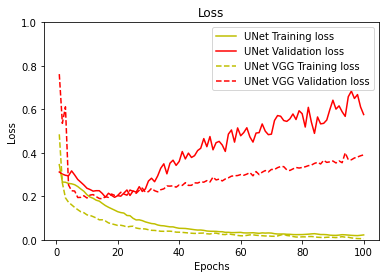

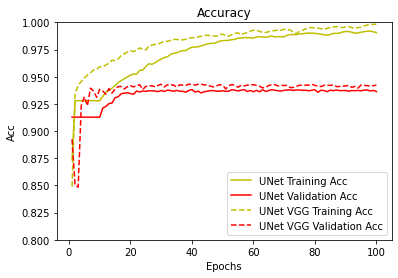

In [23]:
#plot the training and validation IoU and loss at each epoch
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']
epochs = range(1, 100 + 1)
plt.plot(epochs, loss_1, 'y-', label='UNet Training loss')
plt.plot(epochs, val_loss_1, 'r-', label='UNet Validation loss')
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
epochs = range(1, 100 + 1)
plt.plot(epochs, loss_2, 'y--', label='UNet VGG Training loss')
plt.plot(epochs, val_loss_2, 'r--', label='UNet VGG Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend()
plt.show()

acc_1 = history_1.history['acc']
val_acc_1 = history_1.history['val_acc']
acc_2 = history_2.history['acc']
val_acc_2 = history_2.history['val_acc']

plt.plot(epochs, acc_1, 'y-', label='UNet Training Acc')
plt.plot(epochs, val_acc_1, 'r-', label='UNet Validation Acc')
plt.plot(epochs, acc_2, 'y--', label='UNet VGG Training Acc')
plt.plot(epochs, val_acc_2, 'r--', label='UNet VGG Validation Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.ylim([0.8, 1])
plt.legend()
plt.show()

In [24]:
#Predict on the test data
y_pred_1=model_unet.predict(X_test)
y_pred_argmax_1=np.argmax(y_pred_1, axis=3)
y_pred_2=model_unet_vgg.predict(X_test)
y_pred_argmax_2=np.argmax(y_pred_2, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

In [25]:
IOU_keras_1 = MeanIoU(num_classes=2)  
IOU_keras_1.update_state(y_test_argmax, y_pred_argmax_1)
print("Mean IoU Test UNet=", IOU_keras_1.result().numpy())
IOU_keras_2 = MeanIoU(num_classes=2)  
IOU_keras_2.update_state(y_test_argmax, y_pred_argmax_2)
print("Mean IoU Test UNet VGG=", IOU_keras_2.result().numpy())

Mean IoU Test UNet= 0.6712806
Mean IoU Test UNet VGG= 0.69233143


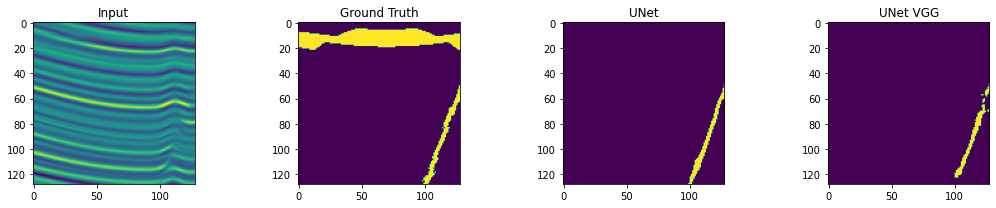

In [26]:
plt.figure(figsize=(15, 3))
ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)
randil = np.random.randint(0, len(X_test), 1)[0]
ax1.imshow(X_test[randil, : , :, 1].T)
ax2.imshow(y_test_argmax[randil, : , :].T)
ax3.imshow(y_pred_argmax_1[randil, : , :].T)
ax4.imshow(y_pred_argmax_2[randil, : , :].T)
ax1.set_title('Input')
ax2.set_title('Ground Truth')
ax3.set_title('UNet')
ax4.set_title('UNet VGG')
plt.tight_layout()
plt.show()

In [27]:
# Prediction
seismic = np.reshape(np.fromfile("/content/drive/MyDrive/UTP_dGB_Documents/data/prediction/f3d/gxl.dat",dtype=np.single),(512,384,128))
seismic.shape

(512, 384, 128)

In [29]:
def prediction(model):
  # Append 2D seismic into 3D seismic
  predicted = []
  for i in range(512):
    val_input = seismic[i, :, :]
    patches = patchify(val_input, (128, 128), step=128)
    predicted_patches = []
    for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
        single_patch = patches[i,j,:,:]
        single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
        single_patch_3ch_input = np.expand_dims(single_patch_3ch, axis=0)
        single_patch_prediction = model.predict(single_patch_3ch_input)
        single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=3)[0,:,:]
        predicted_patches.append(single_patch_prediction_argmax)
    predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patches.shape[2], patches.shape[3]))
    reconstructed_seismic = unpatchify(predicted_patches_reshaped, val_input.shape)
    predicted.append(reconstructed_seismic)
  return np.reshape(predicted, (512, 384, 128))

In [30]:
# def prediction(model):
#   il_range = np.arange(0, 640, 128)
#   pred_3d = []
#   for i in range(384):
#     pred_2d = []
#     for j in range(0, 4):
#       il_min = il_range[j]
#       il_max = il_range[j+1]
#       seis = seismic[il_min:il_max, i, :]
#       pred = np.stack((seis,)*3, axis=-1)
#       pred_2d.append(pred)
#     pred_3d.append(np.vstack(np.argmax(model.predict(np.array(pred_2d)), axis=3)))
#   return np.array(pred_3d).reshape(512, 384, 128)

In [31]:
unet_prediction = prediction(model_unet)

In [32]:
unet_vgg_prediction = prediction(model_unet_vgg)

In [39]:
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
color_array[:,-1] = np.linspace(0.0,0,ncolors)
color_array[255:256] = [1, 0.0, 0., 1]
map_object = LinearSegmentedColormap.from_list(name='fault',colors=color_array)
plt.register_cmap(cmap=map_object)

In [40]:
vm = np.percentile(seismic, 99)

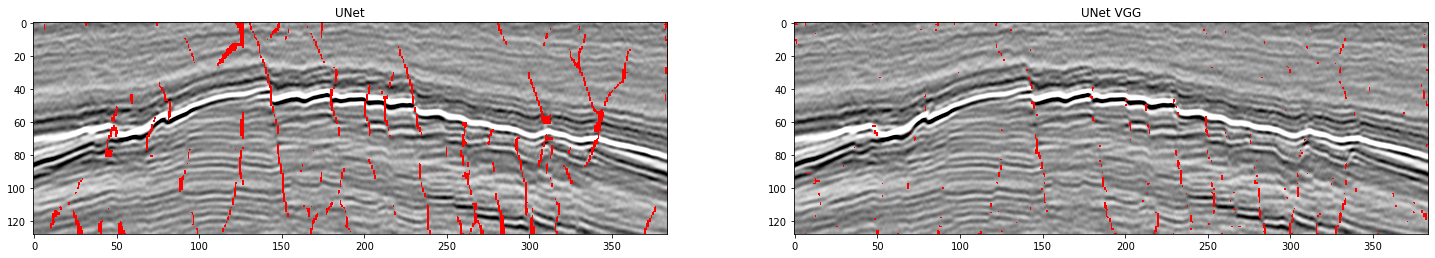

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))
ax[0].imshow(seismic[114,:,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[0].imshow(unet_prediction[114, :, :].T, cmap='fault')
ax[0].set_title('UNet')
ax[1].imshow(seismic[114,:,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[1].imshow(unet_vgg_prediction[114, :, :].T, cmap='fault')
ax[1].set_title('UNet VGG')
plt.show()